# [Zindi: Financial Inclusion in Africa](https://zindi.africa/competitions/financial-inclusion-in-africa)


## Predict who is most likely to have a bank account.

Financial Inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 13.9% of the adult population) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and facilitate payments while also helping businesses build up their credit-worthiness and improve their access to other finance services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this project is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key demographic factors that might drive individuals’ financial outcomes.

The main dataset contains demographic information and what financial services are used by approximately 33,610 individuals across East Africa. This data was extracted from various Finscope surveys ranging from 2016 to 2018. Your goal is to accurately predict the likelihood that an individual has a bank account or not, i.e. Yes = 1, No = 0.

# Setup

You may need to run the following code cell to install all of the packages that are required:
    

In [ ]:
# !pip install -U imbalanced-learn

In [ ]:
#! conda install -c glemaitre imbalanced-learn

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

sns.set()

%matplotlib inline

# Data Preparation

## Load the data

We are given a training and test data set, as well as definitions of all of the features.

In [3]:
data = pd.read_csv('data/train.csv')
definitions = pd.read_csv('data/VariableDefinitions.csv')

## Peek at the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


## What do the features/vairables mean?

In [5]:
with pd.option_context('display.max_colwidth', None):
  display(definitions)

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,"The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know"
9,marital_status,"The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know"


## Descriptive Statistics

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [6]:
# Numeric data
data.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [7]:
# Other types of data (categorical)
data.describe(include=['O'])

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_735,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


## Drop irrelevant features
`uniqeid` will not be of use to a model, because it is simply a unique identifier.

In [8]:
data.drop("uniqueid", axis=1, inplace=True)

## Check for any missing values

In [9]:
data.isnull().sum()

country                   0
year                      0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

# Exploratory Data Analysis

## Analysing input features:

There are two continuous features: `household_size`, `age_of_respondent`

The remaining features are all nominal.

We can analyze continous/quantitative attributes with histograms and boxplots. The distribution of each attribute is analyzed individually.

## Univariate Analysis

The first histogram is a density histogram and a kernel density estimate, and the second is the absolute frequencies of the attribute, with some adjustments to ticks and bins. 

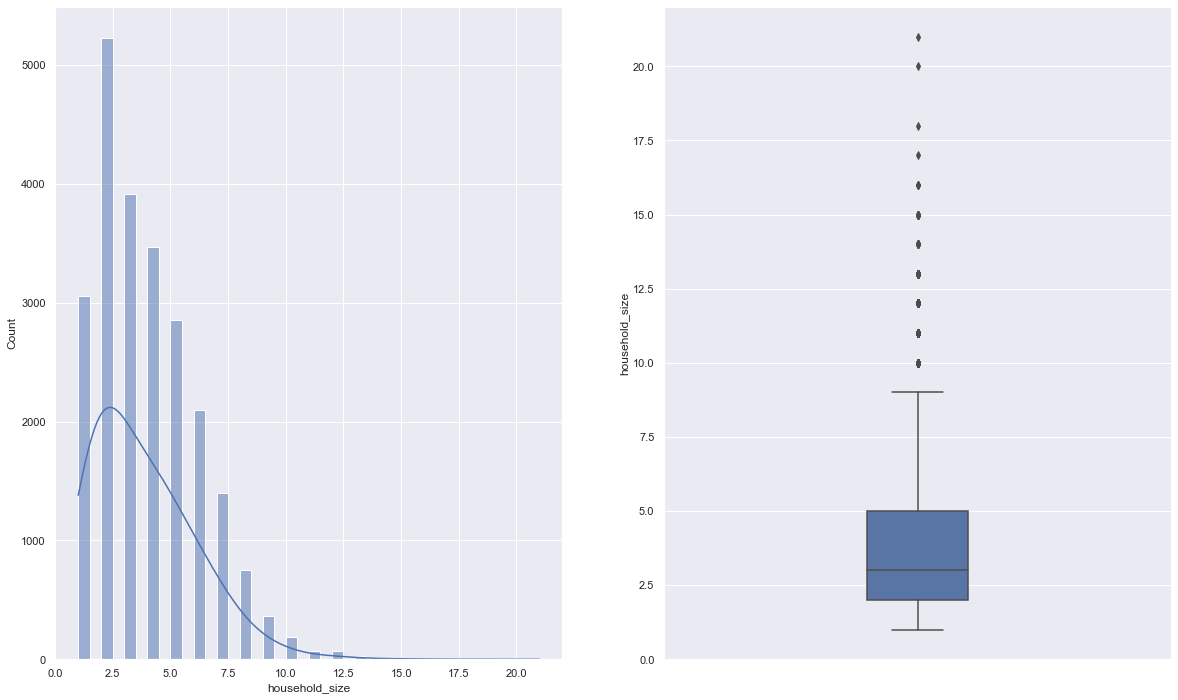

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

# histogram
sns.histplot(
    data['household_size'], 
    bins=np.arange(1, 21, 0.5), 
    kde=True,  
    kde_kws={"bw_adjust":3}, 
    ax = ax[0]
)
# boxplot
sns.boxplot(data=data, y='household_size', width=0.2, ax=ax[1])
plt.show()

In [11]:
# Count outliers in the household_size column
Q1 = data.household_size.quantile(0.25)
Q3 = data.household_size.quantile(0.75)

IQR = Q3 - Q1

outliers = ((data.household_size < Q1 - 1.5 * IQR) | (data.household_size > Q3 + 1.5 * IQR))
outliers.value_counts()

False    23143
True       381
Name: household_size, dtype: int64

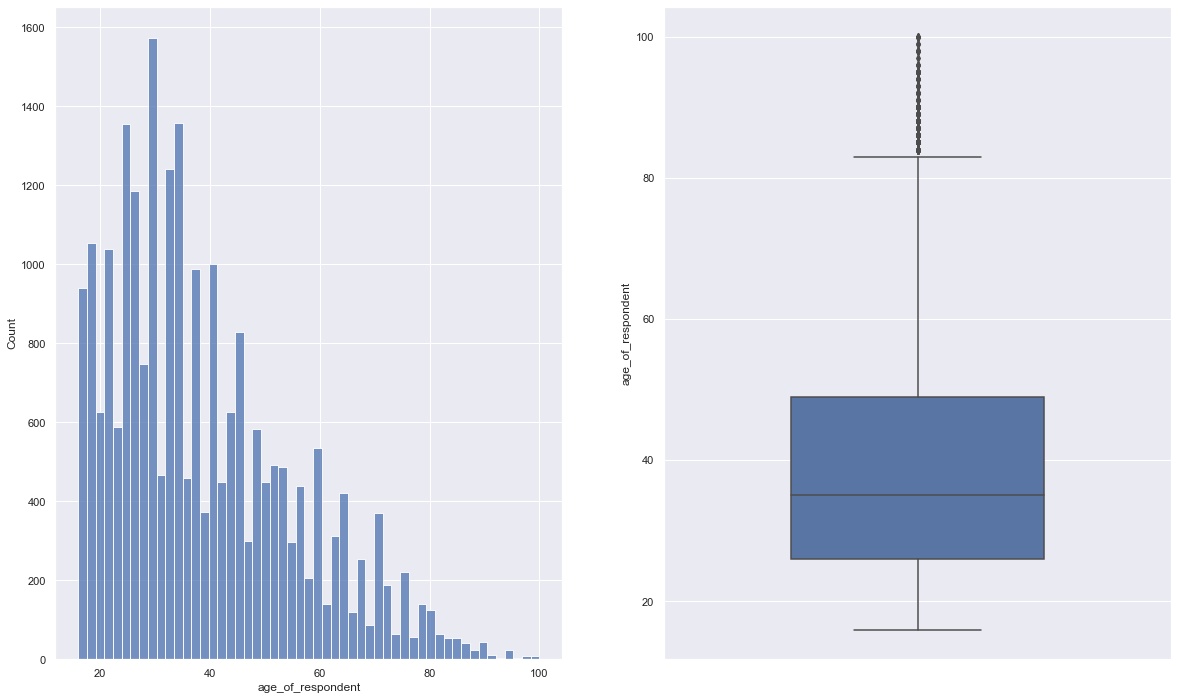

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,12))

# histogram
sns.histplot(data['age_of_respondent'], ax = ax[0])
# boxplot
sns.boxplot(data=data, y='age_of_respondent', width=0.5, ax=ax[1])
plt.show()

In [13]:
#Count outliers in the age_of_respondent column
Q1 = data.age_of_respondent.quantile(0.25)
Q3 = data.age_of_respondent.quantile(0.75)

IQR = Q3 - Q1

outliers = ((data.age_of_respondent < Q1 - 1.5 * IQR) | (data.age_of_respondent > Q3 + 1.5 * IQR))
outliers.value_counts()

False    23283
True       241
Name: age_of_respondent, dtype: int64

We have a fairly large amount of outliers on both these features and opt to leave these records in.

Removing them can possibly deteriorate our model performance, as the model looses a considerable amount of training instances.

We should therefore choose a model robust to outliers to compensate for this.

## Bivariate analysis

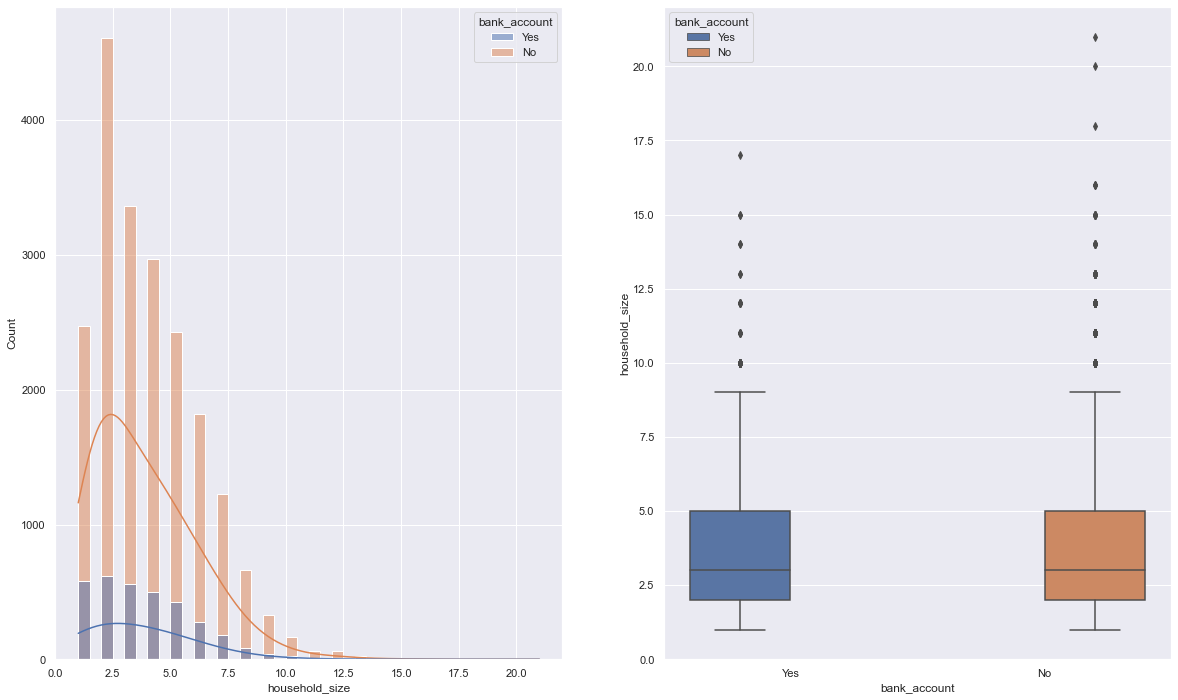

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

# histogram
sns.histplot(
    data=data,
    x = "household_size",
    hue="bank_account",
    bins=np.arange(1, 21, 0.5), 
    kde=True,  
    kde_kws={"bw_adjust":3}, 
    ax = ax[0]
)
# boxplot
sns.boxplot(
    data=data, 
    y='household_size', 
    x="bank_account",
    hue="bank_account",
    ax=ax[1]
)
plt.show()

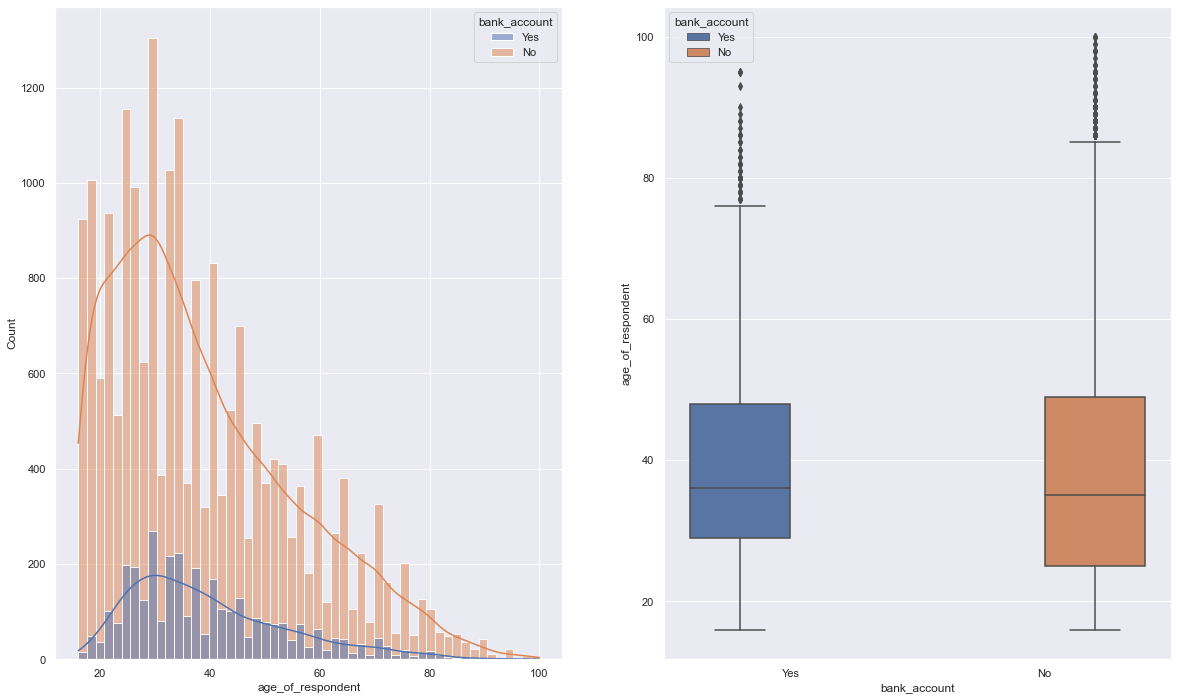

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

# histogram
sns.histplot(
    data=data,
    x = "age_of_respondent",
    hue="bank_account",
    kde=True,  
    ax = ax[0]
)
# boxplot
sns.boxplot(
    data=data, 
    y='age_of_respondent', 
    x="bank_account",
    hue="bank_account",
    ax=ax[1]
)
plt.show()

The most prominent pattern here is the high imblance in target classes. This is clearly visible in the histograms.

It also seems that there is no large difference in the distribution of household_size, depending on whether the person has a bank account or not.

For the individual's age however, there is a slight tendency for older aged individuals to have a bank account.

## Multi-variate analysis

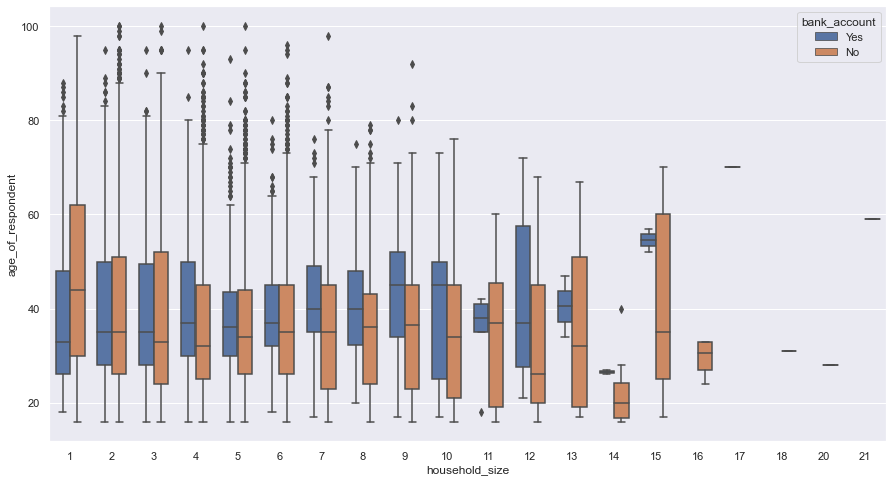

In [16]:
# boxplot
plt.figure(figsize=(15,8))

sns.boxplot(
    data=data, 
    y='age_of_respondent', 
    x='household_size', 
    hue='bank_account', 
    width=0.7
)

plt.show()

When both these features are analysed simultaneosly against the target variable, we see a that the relationship of older ages being more likely to have a bank account holds mostly true. 

However for individuals staying alone, this relationship is flipped. 

## Categorical (Nominal) Features
We seek to visualize the data distributions for the following features:

* `country` 
* `location_type` 
* `cellphone_access`
* `gender_of_respondent`
* `relationship_with_head` 
* `marital_status`
* `education_level`
* `job_type`

These categorical attributes are analyzed using bar plots.

## Bivariate analysis

In [6]:
categorical_attributes = [
    "country", 
    "location_type", 
    "cellphone_access", 
    "gender_of_respondent", 
    "relationship_with_head",
    "marital_status",
    "education_level",
    "job_type"
]

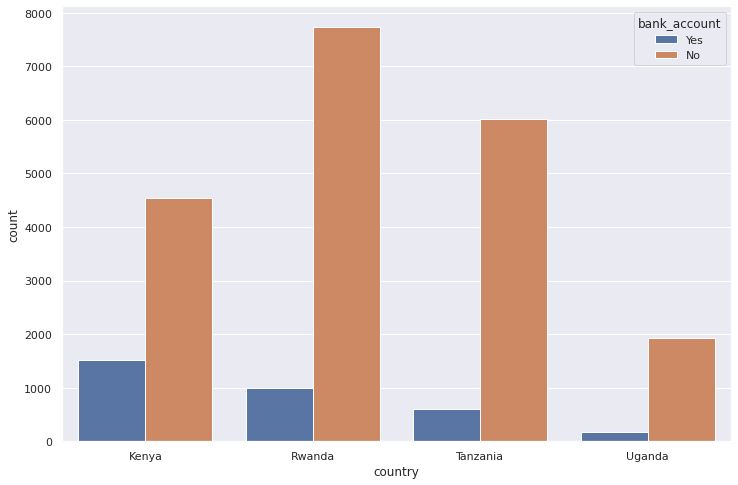

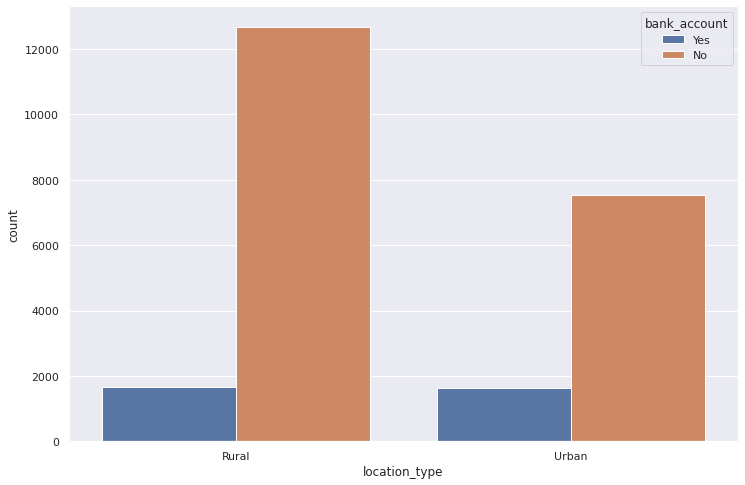

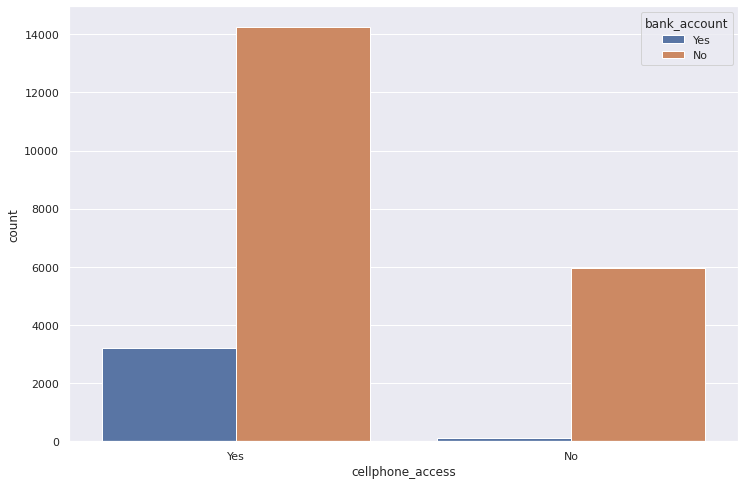

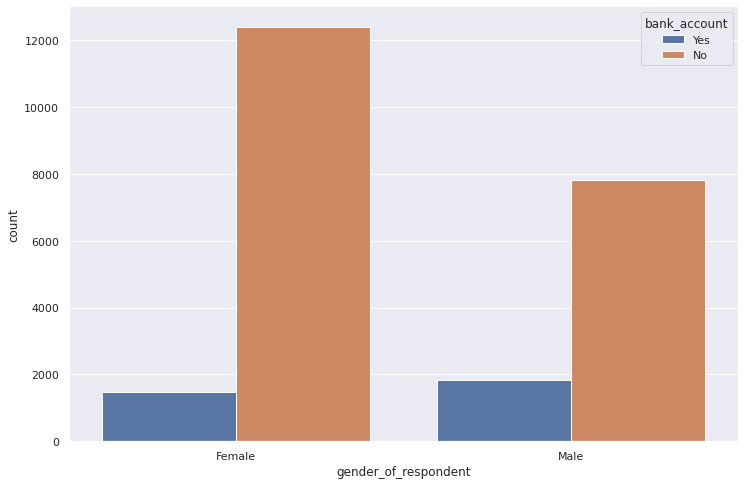

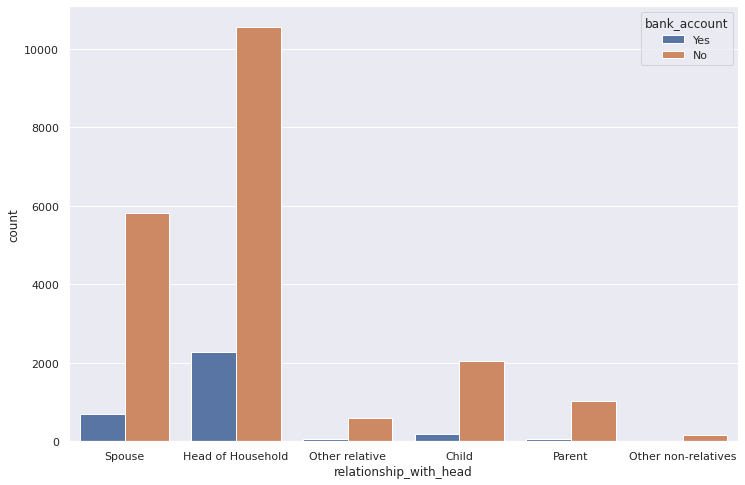

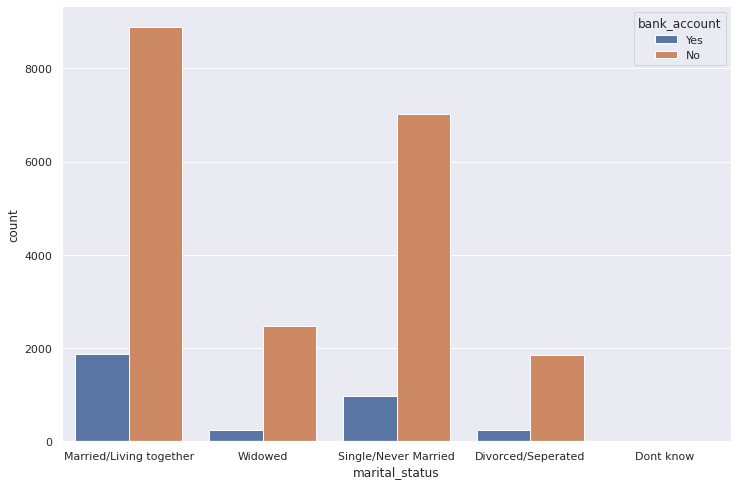

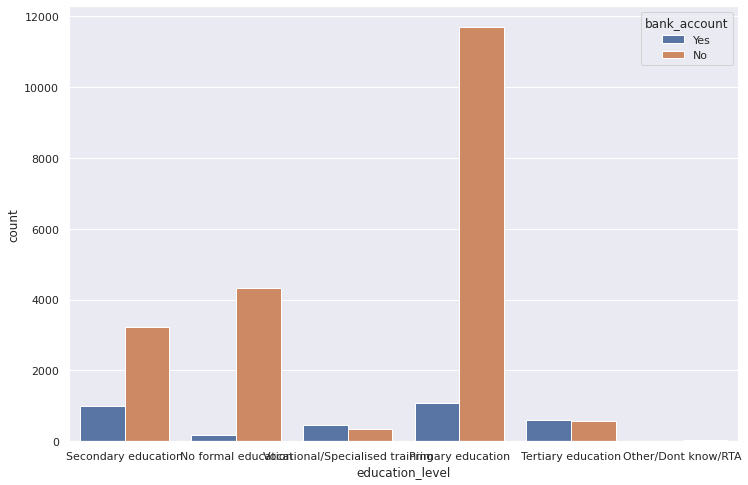

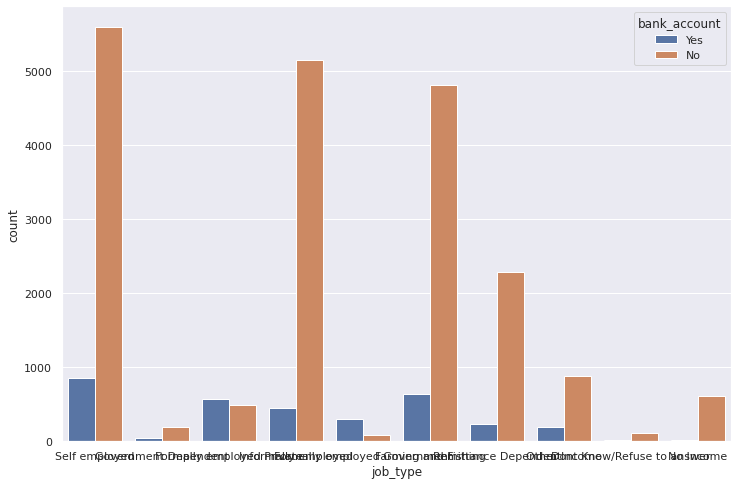

In [13]:
for i, cat in enumerate(categorical_attributes):
    plt.figure(figsize=(12, 8))
    sns.countplot(
        data=data,
        x=cat,  
        hue='bank_account', 
    )

## Univariate analysis of the target feature


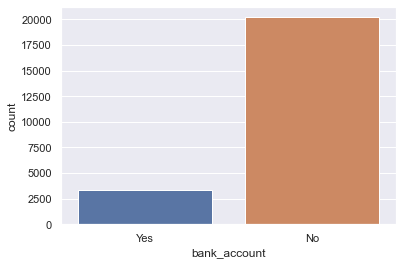

In [19]:
sns.countplot(x='bank_account', data=data)
plt.show()

Notice the number of observations in the dataset with `bank_account` = `Yes` is much less than `No`

## Exploratory data analysis conclusion

Due to the majority of people not having a bank account, we have a problem where the predictor variable (`bank_account`) is highly unbalanced. It is important to account for this, to ensure the final model produces adequate performance.

Imbalanced classification poses a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

Either the minority label in the dataset can be oversampled, or the majority label undersampled. We can also remedy this imbalance by chosing a model robust to class imbalance. Decision trees are robust to both outliers as well as imbalanced datasets, due to their splitting rules, recursively partitioning the feature space to ensure both classes are thoroughly trained for.


Furthermore all variables show correlation to some extent with the target variable. Non are omitted from the final model.




# Enoding the data
Next we need to convert the strings in our dataset into integers/floats otherwise our model would be unable to interpret them.

For the predictor variable we simply replace `Yes` and `No` with `1` and `0`, respectively.

In [20]:
data['bank_account'] = data['bank_account'].apply(lambda x: 0 if x == 'No' else 1)
data.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


Because we are working with nominal (not ordinal) data it is import that it be one-hot-encoded. 

Thereby we avoid imposing any sort of linear relationship onto these nominal attributes.


In [21]:
X = pd.get_dummies(data, drop_first=True)
X.head()

,year,bank_account,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,1,3,24,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2018,0,5,70,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2018,1,5,26,0,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
3,2018,0,5,34,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2018,0,8,26,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


## Splitting Data
We can now proceed to seperate the predictor variable (`y`) from the input variables (`X`). 

Thereafter we split the dataset into a training, validation and testing sets.
We split the data as follows:
* 80% of the data is in the training set
* 10% of the data is in the validation set
* the final 10% of the data is in the testing set

In [22]:
# for the training data
y = X.bank_account.values
X.drop('bank_account', axis=1, inplace=True)

In [23]:
# split training data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# split the data again, to obtain the validation and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42)

## Scaling data
Next we scale the input data, so that all features have a mean of 0 and a standard deviation of 1.

Differences in the scales across input variables may increase the difficulty of the problem being modeled. An example of this is that large input values (e.g. a spread of hundreds or thousands of units) can result in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error.

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)
X_test = sc.fit_transform(X_test)

## Training the model
We will be optimising the hyperparameters of the model by training several models with differing hyperparameter values and comparing their performance on the validation set.

There are a number of hyperparameter involved in Random Forest Classifiers. Those applicable here are:
 - Minimum samples per leaf node
 - Ensemble size
 - Maximum tree depth

Leaving the depth of a tree unrestrained will result in trees with large variance. This is not a problem because by decorrelating our trees (this is where the random, in random forest comes to play) and ensembling them thereafter, we can drive the final variance of our model significantly down. Therefore, this hyperparameter is assigned the default value of 'None'.

The larger the ensemble size, the lower that variance error will be driven. However, there are diminishing returns and an increase in computational cost associated with increasing this hyperparameter. We leave this value as the default value of 100.

The final hyperparmater that we will be tuning for is the minimum samples per leaf node. 
Leaving this value to be the default of 1 could benefit our model's capability to naturally handle outliers.
Note that doing so could cause our model to overfit on the dataset. Assigning a value of 10, for example, would result in the average over a minimum of 10 observations being used to determine the output of a leave node. Beyond a certain value, this will prevent Random Forest from handling the class imbalance properly. 

We will tune this hyperparameter by training models with the following values:
\[1, 2, 3, 5, 10, 15\]

The best performing value will be chosen for the final model.

 
  

In [25]:
models = []
parameters = [1, 2, 3, 5, 10, 15]

for i, value in enumerate(parameters):
    models.append(RandomForestClassifier(n_jobs=-1, min_samples_leaf=value))
    models[i].fit(X_train, y_train)

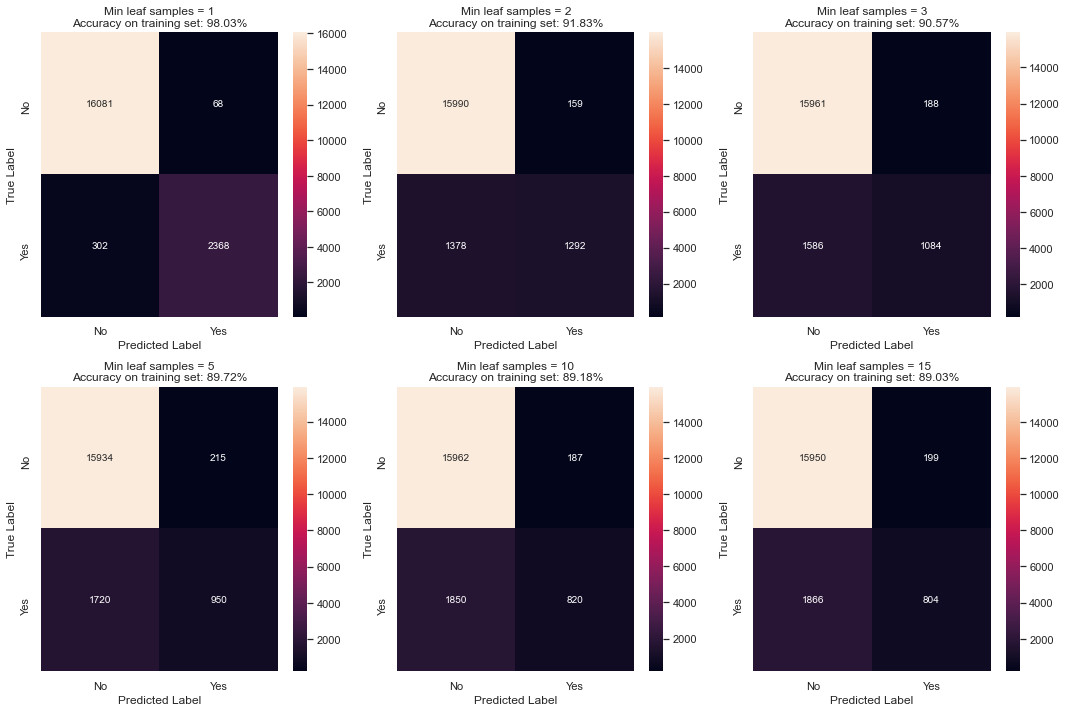

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
train_score = []

for i, axes in enumerate(ax):    
    # predict values
    train_pred = models[i].predict(X_train)
    
    # print confusion matrix
    labels = ['No', 'Yes']
    sns.heatmap(
        confusion_matrix(y_train, train_pred), 
        annot=True, 
        fmt='d', 
        yticklabels=labels, 
        xticklabels=labels, 
        ax=axes
    )
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(y_train, train_pred) * 100
    train_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on training set: {:.2f}%".format(parameters[i], score))


plt.tight_layout()

Things to notice here:
 - For minimum leaf samples set to 1 there are very little false negatives, showing that random forest can account for class imbalance. However, this could be accompanied by overfitting.
 - The number of True negatives is consistent throughout.
 - The model's variance is decreased with increase in minimum leaf samples. This is clear through the decline in flase negatives.

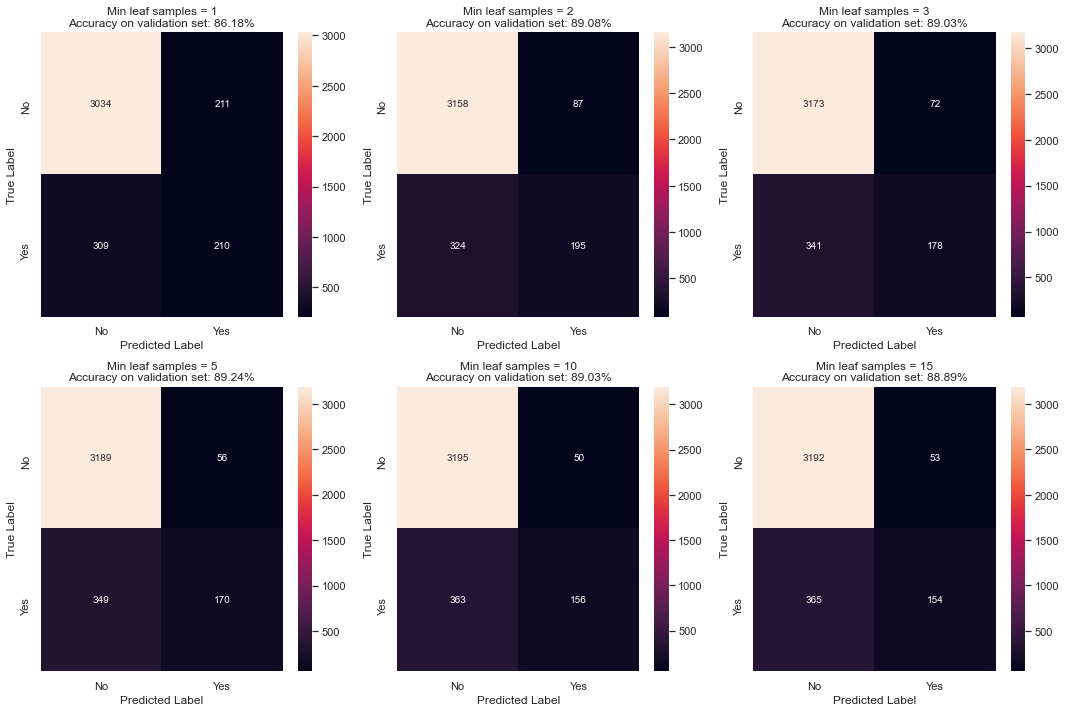

In [27]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

for i, axes in enumerate(ax):
    # predict values 
    valid_pred = models[i].predict(X_valid)
    
    # print confusion matrix
    labels = ['No', 'Yes']
    sns.heatmap(
        confusion_matrix(y_valid, valid_pred),
        annot=True,
        fmt='d',
        yticklabels=labels,
        xticklabels=labels, 
        ax=axes
    )
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(y_valid, valid_pred) * 100
    valid_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on validation set: {:.2f}%".format(parameters[i], score))


plt.tight_layout()

Looking at the results on the validation set confirms that the model did indeed overfit for minimum leaf samples set to 1. Shown by the high amount of false positives and low accuracy. However, this did result in the lowest overall number of false negatives. 

The model initially showed good performance on the training set, regardless of the high class imbalance. However, on the validation set its performance degraded significantly. Considering how large the imbalance was Random Forest performed quite well without any resampling of the dataset.

The biggest problem is that we are classifying someone who actually has a bank account wrongly, more often than not. The number of false negatives are greater than true positives.

## To illustrate the point of overfitting.

In [28]:
results = {
    'Min_leaf_samples': parameters, 
    'Train Score': train_score, 
    'Valid Score': valid_score
}

result_df = pd.DataFrame(results)
result_df

,Min_leaf_samples,Train Score,Valid Score
0,1,98.033902,86.184910
1,2,91.832722,89.080765
2,3,90.573357,89.027630
3,5,89.717838,89.240170
4,10,89.175833,89.027630
5,15,89.027047,88.894793


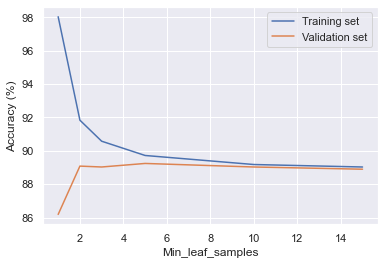

In [29]:
sns.lineplot(data=result_df, x='Min_leaf_samples', y='Train Score', label='Training set')
sns.lineplot(data=result_df, x='Min_leaf_samples', y='Valid Score', label= 'Validation set')
plt.ylabel('Accuracy (%)')
plt.show()

The ideal value for the hyperparameter seems to be 5. However, we alreay know that there are more false negatives than false positives for both the training set and the validation set for this value. As well as a much larger number of false negatives as apposed to true positives. 

The model is great at predicting if people don't have a bank account. Unfortunately the same cannot be said for the inverse.

Leaving the model in this state would be fallacious as the highly imbalanced classes still results in the model producing too many false negatives, regardless of its accuracy score.

# Therefore we opt to tackle the class imbalance artificially.

Our goal here is to minimise the ratio of the predictor variable. To do so, the minority class must be increased in size, and the majority class decreased.

There are several different techniques to achieve this, here we decide to use [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Over-sampling Technique) combined with random under sampling.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. This approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.

In [30]:
counter = Counter(y_train)
print('Class count before:', counter)

# over sample minority to equal 20% of the majority's size
over = SMOTE(sampling_strategy = 0.2)

# under sample majority to have the minority class equal 50% of the majority's size
under = RandomUnderSampler(sampling_strategy = 0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('Class count after:', counter)

sampled_models = []
parameters = [1, 3, 5, 10, 20, 50]

i=0
for value in parameters:
    sampled_models.append(RandomForestClassifier(n_jobs=-1, min_samples_leaf=value))
    sampled_models[i].fit(X_train, y_train)
    i+=1

Class count before: Counter({0: 16149, 1: 2670})
Class count after: Counter({0: 6458, 1: 3229})


It is important that we do not completely flood the training set with artificial data. 

Furthermore, it is not realizable to bring the minority class to an equal amount as the majority class without comprimising the integrity of the data. Therefore we simply aim to reduce the large difference between these classes.

The final training set will be smaller than the previous, but with the majority class being only twice as large as the minority (originally this was about eight times). 

## Repeat the performance measures
Note that we are now tuning for minimum leaf samples up to 50.

Due to the increase in minority class.

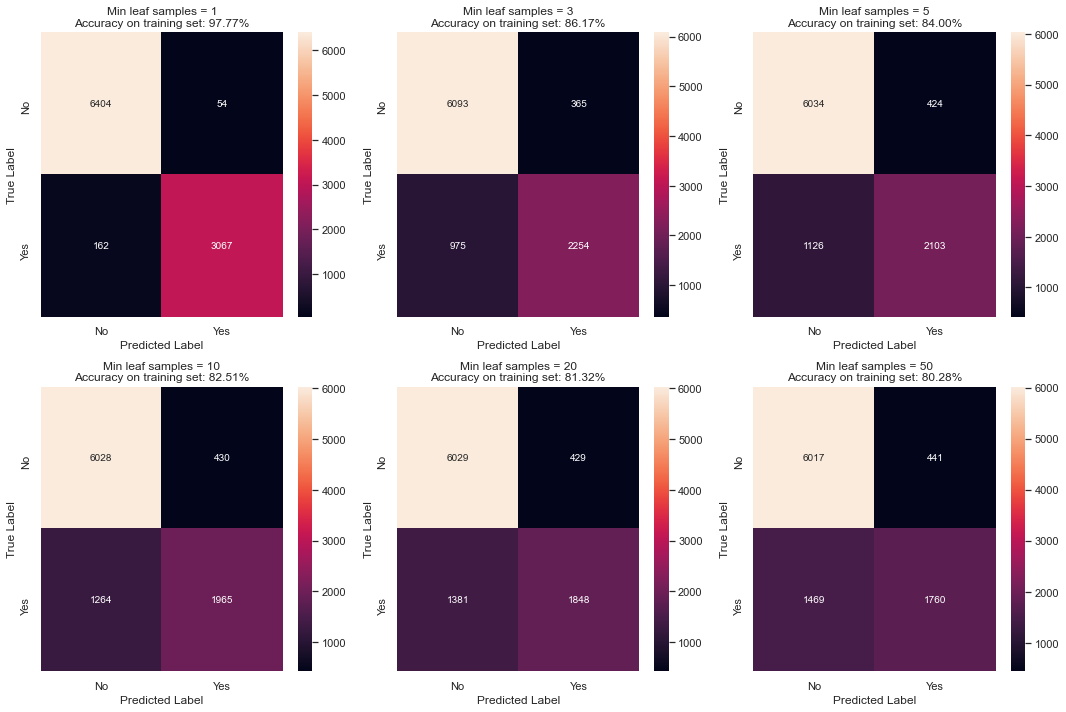

In [31]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
train_score = []

i=0
for axes in ax:
    # predict values
    trainPredicted = sampled_models[i].predict(X_train)
    

    # print confusion matrix
    labels = ['No', 'Yes']
    sns.heatmap(
        confusion_matrix(y_train, trainPredicted),
        annot=True,fmt='d', 
        yticklabels=labels,
        xticklabels=labels, 
        ax=axes
    )
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    
    # compute score
    score = accuracy_score(y_train, trainPredicted) * 100
    train_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on training set: {:.2f}%".format(parameters[i],score))
    i+=1

plt.tight_layout()

Note:
- For all values of minimum leaf sampels, the model now has enough training instances to predict the correct label more often than not.
- These results cannot be directly compared to the previous models, as this is a different data set.
- However the validation set remains unchanged and will provide an unbiased evaluation.


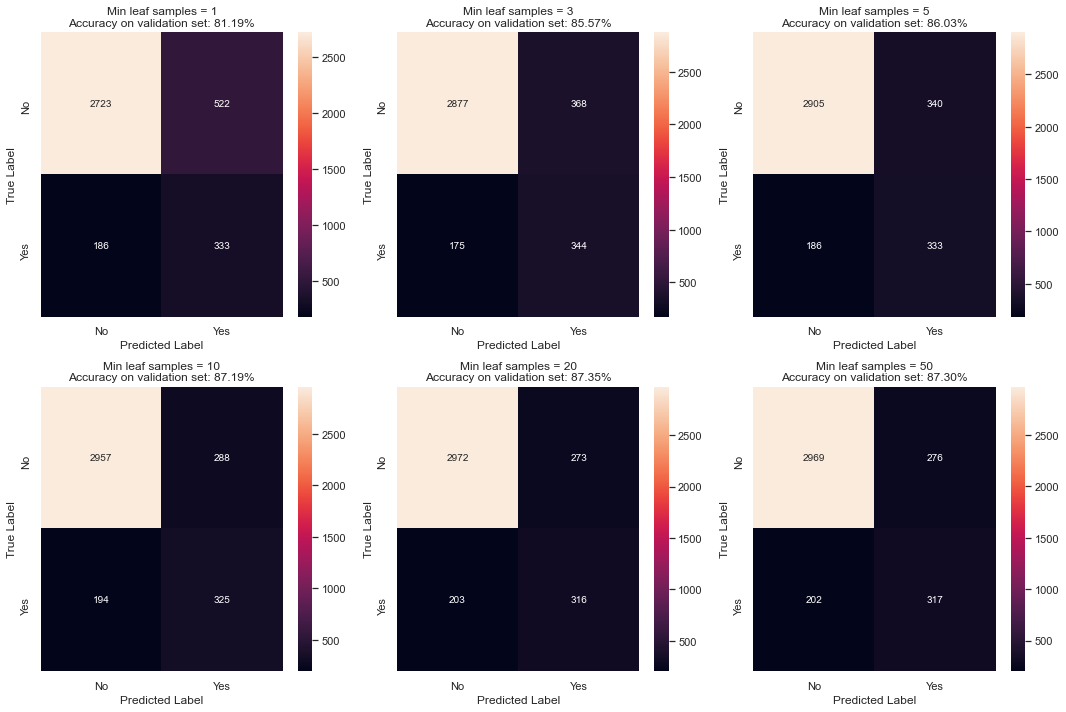

In [32]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()
valid_score = []

i=0
for axes in ax:
    # predict values 
    valid_pred = sampled_models[i].predict(X_valid)
    
    # print confusion matrix
    labels = ['No', 'Yes']
    sns.heatmap(
        confusion_matrix(y_valid, valid_pred),
        annot=True,
        fmt='d',
        yticklabels=labels,
        xticklabels=labels, 
        ax=axes
    )
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')

    # compute score
    score = accuracy_score(y_valid, valid_pred) * 100
    valid_score.append(score)
    axes.set_title("Min leaf samples = {}\nAccuracy on validation set: {:.2f}%".format(parameters[i],score))
    i+=1

plt.tight_layout()

Compared to the performance before over/under sampling the training set, the accuracy score is slightly less.

However, the ratio of falsely predicting the minority class is significantly improved for all values of the hyperparameter.

# Final performance on the test set.
Here we compare the performance before and after under/over sampling.

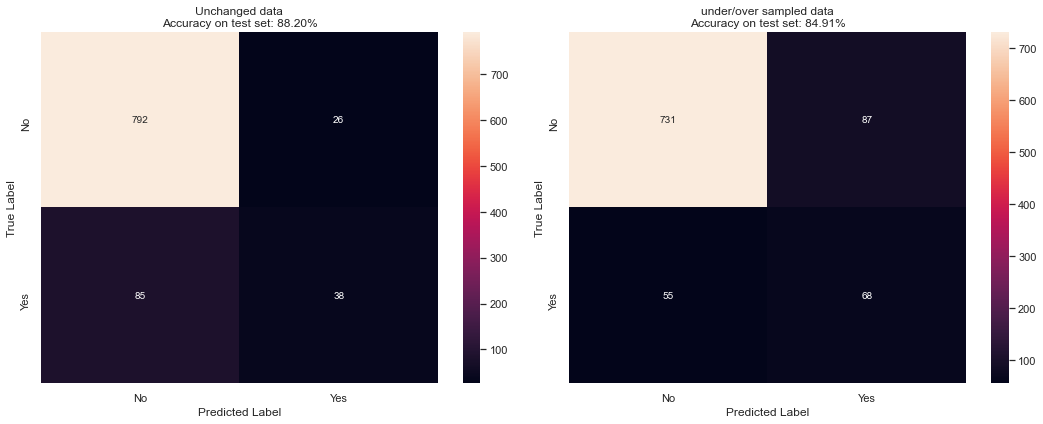

In [33]:
fig , ax = plt.subplots(1,2,figsize=(15,6))
ax = ax.flatten()
labels = ["No", "Yes"]

# model 1
test_pred = models[1].predict(X_test)
sns.heatmap(
    confusion_matrix(y_test, test_pred),
    annot=True,fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[0]
)
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')
score = accuracy_score(y_test, test_pred) * 100
ax[0].set_title("Unchanged data\nAccuracy on test set: {:.2f}%".format(score))

# model 2
test_pred = sampled_models[4].predict(X_test)
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_test, test_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[1]
)
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')
score = accuracy_score(y_test, test_pred) * 100
ax[1].set_title("under/over sampled data\nAccuracy on test set: {:.2f}%".format(score))

plt.tight_layout()

# To conclude:
It is clear that one cannot simply look to accurcay metrics to determine if your model is performing adequetely.

In this case the first model has a higher accurcay, but performs unsatisfactory if you consider the false positive and false negative ratios.


# Comparing models, improving performance and ensuring reproducibility

The minimum steps requirements for this assignment are the following:
- Use 3 different machine learning algorithms **[15 marks]**
- Use hyperparameter tuning (see [sklearn's grid search here](https://scikit-learn.org/stable/modules/grid_search.html)) **[5 marks]**
- Compare the performances between the algorithms, and recommend which algorithm (and hyperparameters) should be used. Please motivate why you choose your model. **[10 marks]**
- Your experiments **must** be reproducible; this means you must make sure you set `random_state` in the appropriate places, and so on. For more information, see the following [sklearn documentation](https://scikit-learn.org/0.24/common_pitfalls.html#controlling-randomness). **[5 marks]**

Some other suggestions of what you can do with this assignment, for a total of **10 marks** :
- Use the `Pipeline` feature from sklearn (helps with consistency, see more [here](https://scikit-learn.org/0.24/common_pitfalls.html#inconsistent-preprocessing))
- Try other data preprocessing steps
- Try use neural networks